## Section 1: Environment Setup and Basic Board Implementation

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Tuple
from dataclasses import dataclass
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import random
from collections import deque, defaultdict
import math

In [5]:
@dataclass
class Move:
    start_pos: Tuple[int, int]
    end_pos: Tuple[int, int]
    captures: List[Tuple[int, int]]  # positions of captured places

In [6]:
class CheckersBoard:
    def __init__(self):
        self.BOARD_SIZE = 8
        self.reset()
    
    def reset(self):
        self.board = np.zeros((self.BOARD_SIZE, self.BOARD_SIZE))
        # Initialize pieces: 1 for red (player 1), -1 for black (player 2)
        # Set up the initial board position
        for row in range(3):  # Red pieces (top)
            for col in range(self.BOARD_SIZE):
                if (row + col) % 2 == 1:
                    self.board[row][col] = 1
        for row in range(5, self.BOARD_SIZE):  # Black pieces (bottom)
            for col in range(self.BOARD_SIZE):
                if (row + col) % 2 == 1:
                    self.board[row][col] = -1
        self.current_player = 1  # Red always starts
        return self.get_state()

    def get_state(self):
        state = np.zeros((4, self.BOARD_SIZE, self.BOARD_SIZE))
        state[0] = (self.board == 1).astype(float)
        state[1] = (self.board == -1).astype(float)
        state[2] = (self.board == 2).astype(float)
        state[3] = (self.board == -2).astype(float)
        return state
    
    def get_legal_moves(self) -> List[Move]:
        """Get all legal moves for the current player."""
        moves = []
        # First check for any capture moves (these are mandatory in checkers)
        for row in range(self.BOARD_SIZE):
            for col in range(self.BOARD_SIZE):
                if self.board[row][col] * self.current_player > 0:  # If piece belongs to current player
                    piece_captures = self._get_capture_moves(row, col)
                    moves.extend(piece_captures)

        # If no captures are available, get regular moves
        if not moves:
            for row in range(self.BOARD_SIZE):
                for col in range(self.BOARD_SIZE):
                    if self.board[row][col] * self.current_player > 0:
                        piece_moves = self._get_regular_moves(row, col)
                        moves.extend(piece_moves)
        return moves

    def _get_piece_moves(self, row: int, col: int) -> List[Move]:
        """Get all possible moves for a specific piece."""
        # Check for captures first (mandatory)
        captures = self._get_capture_moves(row, col)
        if captures:
            return captures

        # If no captures, return regular moves
        return self._get_regular_moves(row, col)

    def _get_regular_moves(self, row: int, col: int) -> List[Move]:
        """Get non-capturing moves for a piece."""
        moves = []
        piece = self.board[row][col]
    
        # Define move directions (up vs down)
        if piece == 1:  # Red regular pieces move down
            directions = [(1, -1), (1, 1)]
        elif piece == -1:  # Black regular pieces move up
            directions = [(-1, -1), (-1, 1)]
        elif abs(piece) == 2:  # Kings can move in all directions
            directions = [(-1, -1), (-1, 1), (1, -1), (1, 1)]
        else:
            return moves
    
        # Check each direction
        for dr, dc in directions:
            new_row, new_col = row + dr, col + dc
            if (0 <= new_row < self.BOARD_SIZE and
                0 <= new_col < self.BOARD_SIZE and
                self.board[new_row][new_col] == 0):  # Empty square
                moves.append(Move(
                    start_pos=(row, col),
                    end_pos=(new_row, new_col),
                    captures=[]
                ))
    
        return moves

    def _get_capture_moves(self, row: int, col: int) -> List[Move]:
        """Get capturing moves for a piece."""
        moves = []
        piece = self.board[row][col]

        # Define capture directions based on piece type
        if piece == 1:  # Red regular pieces move down
            directions = [(1, -1), (1, 1)]
        elif piece == -1:  # Black regular pieces move up
            directions = [(-1, -1), (-1, 1)]
        elif abs(piece) == 2:  # Kings can move in all directions
            directions = [(-1, -1), (-1, 1), (1, -1), (1, 1)]
        else:
            return moves

        # Check each direction for captures
        for dr, dc in directions:
            jump_row, jump_col = row + 2*dr, col + 2*dc
            capture_row, capture_col = row + dr, col + dc

            if (0 <= jump_row < self.BOARD_SIZE and
                0 <= jump_col < self.BOARD_SIZE and
                self.board[capture_row][capture_col] * self.current_player < 0 and  # Enemy piece
                self.board[jump_row][jump_col] == 0):  # Empty landing square

                # Create initial capture move
                initial_move = Move(
                    start_pos=(row, col),
                    end_pos=(jump_row, jump_col),
                    captures=[(capture_row, capture_col)]
                )

                # Find any subsequent captures from the landing position
                self._find_multi_captures(jump_row, jump_col, piece, initial_move, moves)

        return moves

    def _find_multi_captures(self, row: int, col: int, piece: int, 
                        current_move: Move, all_moves: List[Move]) -> None:
        """Recursively find multi-capture sequences and add them to all_moves."""
        # First, add the current move as a valid option
        all_moves.append(current_move)
        
        # Check if additional captures are possible from this position
        has_additional_captures = False
        
        # Define capture directions based on piece type
        if piece == 1:  # Red regular pieces move down
            directions = [(1, -1), (1, 1)]
        elif piece == -1:  # Black regular pieces move up
            directions = [(-1, -1), (-1, 1)]
        elif abs(piece) == 2:  # Kings can move in all directions
            directions = [(-1, -1), (-1, 1), (1, -1), (1, 1)]
        else:
            return
        
        # Try each direction
        for dr, dc in directions:
            jump_row, jump_col = row + 2*dr, col + 2*dc
            capture_row, capture_col = row + dr, col + dc
            
            # Check if the jump is valid
            if (0 <= jump_row < self.BOARD_SIZE and
                0 <= jump_col < self.BOARD_SIZE and
                self.board[capture_row][capture_col] * self.current_player < 0 and  # Enemy piece
                self.board[jump_row][jump_col] == 0 and  # Empty landing square
                (capture_row, capture_col) not in current_move.captures):  # Haven't captured this piece yet
                
                # Create a new move by extending the current one
                new_move = Move(
                    start_pos=current_move.start_pos,  # Original starting position
                    end_pos=(jump_row, jump_col),      # New ending position
                    captures=current_move.captures + [(capture_row, capture_col)]  # Add new capture
                )
                
                # Recursively find more captures
                has_additional_captures = True
                self._find_multi_captures(jump_row, jump_col, piece, new_move, all_moves)
        
        # If this position can make additional captures, remove the current move
        # as it's incomplete (player must make the maximum number of captures)
        if has_additional_captures:
            all_moves.remove(current_move)

    def make_move(self, move: Move) -> bool:
        """Execute a move on the board."""
        start_row, start_col = move.start_pos
        end_row, end_col = move.end_pos

        # Validate move
        if not (0 <= start_row < self.BOARD_SIZE and
                0 <= start_col < self.BOARD_SIZE and
                0 <= end_row < self.BOARD_SIZE and
                0 <= end_col < self.BOARD_SIZE):
            return False

        # Verify piece belongs to current player
        if self.board[start_row][start_col] * self.current_player <= 0:
            return False

        # Execute move
        piece = self.board[start_row][start_col]
        self.board[end_row][end_col] = piece
        self.board[start_row][start_col] = 0

        # Remove captured pieces
        for capture_row, capture_col in move.captures:
            self.board[capture_row][capture_col] = 0

        # King promotion
        if (piece == 1 and end_row == 0) or (piece == -1 and end_row == self.BOARD_SIZE - 1):
            self.board[end_row][end_col] = piece * 2  # Convert to king

        # Switch players
        self.current_player *= -1

        return True

1. **Mandatory captures**: The code first checks for any capturing moves, which are mandatory in (English) draughts. Only if no captures are available will regular moves be considered.
2. **Kings**: The code handles both regular pieces and kings (represented by 2 and -2).
3. **Multiple Captures**: The code supports multiple captures in a single turn through recursive checking of additional captures after the initial capture.
4. **King Promotion**: Pieces are automatically prompted to kings when they reach the opposite end of the board.
5. **Move Validation**: The code includes basic validation of moves, including checking board boundaries and piece ownership.

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return F.relu(out)

Initial board state:


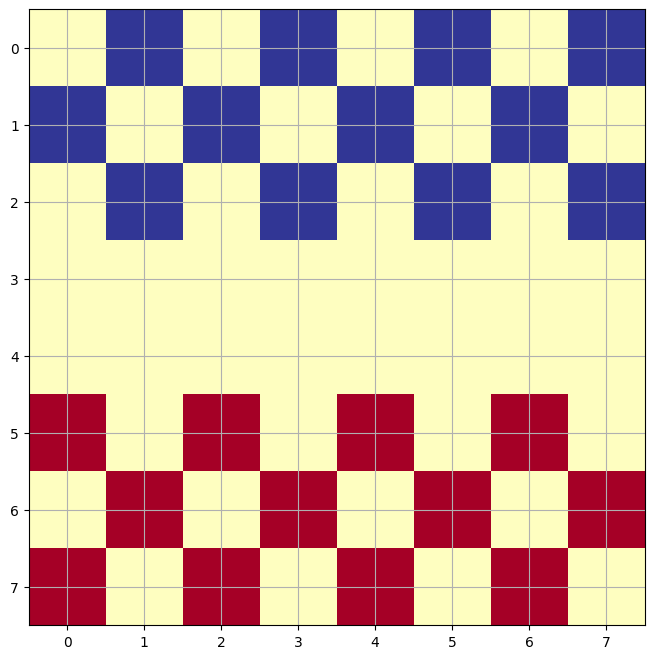

Number of legal moves: 7
Selected move:
From: (2, 1)
To: (3, 0)
Captures: []
Move successful: True

Board after move:


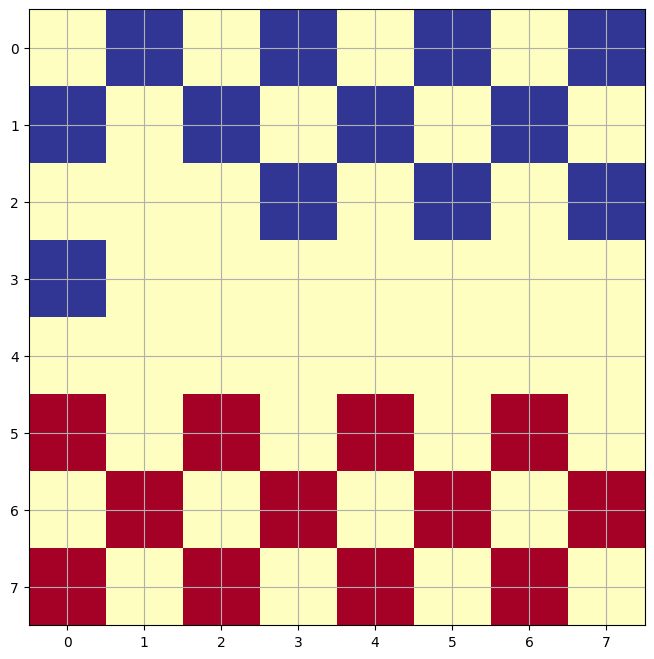

In [5]:
def visualize_board(board: CheckersBoard):
    plt.figure(figsize=(8, 8))
    plt.imshow(board.board, cmap='RdYlBu')
    plt.grid(True)
    plt.show()

# Test the board and moves
board = CheckersBoard()
print("Initial board state:")
visualize_board(board)

legal_moves = board.get_legal_moves()
print(f"Number of legal moves: {len(legal_moves)}")

if legal_moves:
    move = legal_moves[0]
    print(f"Selected move:")
    print(f"From: {move.start_pos}")
    print(f"To: {move.end_pos}")
    print(f"Captures: {move.captures}")

    # Make the move
    success = board.make_move(move)
    print(f"Move successful: {success}")

    print("\nBoard after move:")
    visualize_board(board)
else:
    print("No legal moves found!")

## Section 2: Neural Network Architecture

In [12]:
class CheckersNet(nn.Module):
    def __init__(self):
        super(CheckersNet, self).__init__()

        # Enhanced shared layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(4, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256)
        )

        # Enhanced policy head
        self.policy_head = nn.Sequential(
            nn.Conv2d(256, 128, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 4096),
            nn.LogSoftmax(dim=1)
        )

        # Enhanced value head
        self.value_head = nn.Sequential(
            nn.Conv2d(256, 64, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        policy = self.policy_head(x)
        value = self.value_head(x)
        return policy, value

In [7]:
def test_model():
    model = CheckersNet()
    sample_input = torch.randn(1, 4, 8, 8)
    policy, value = model(sample_input)
    print(f"Policy output shape: {policy.shape}")
    print(f"Value output shape: {value.shape}")
    return model

## Section 3: Training Infrastructure

In [8]:
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, policy, value, reward):
        self.buffer.append((state, policy, value, reward))

    def sample(self, batch_size: int):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        batch = random.sample(self.buffer, batch_size)
        states, policies, values, rewards = zip(*batch)
        return (torch.stack(states),
                torch.stack(policies),
                torch.stack(values),
                torch.tensor(rewards))

    def __len__(self):
        return len(self.buffer)

In [9]:
class CheckersTrainer:
    def __init__(self, model: CheckersNet, device: str = 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Reduced learning rate
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=10
        )
        self.replay_buffer = ReplayBuffer(100000)
        self.batch_size = 128  # Increased batch size

    def train_step(self):
        if len(self.replay_buffer) < self.batch_size:
            return None

        states, policies, values, rewards = self.replay_buffer.sample(self.batch_size)
        states = states.to(self.device)
        policies = policies.to(self.device)
        values = values.to(self.device)
        rewards = rewards.to(self.device)

        self.optimizer.zero_grad()
        pred_policies, pred_values = self.model(states)

        # Weighted loss combination
        policy_loss = F.cross_entropy(pred_policies, policies)
        value_loss = F.mse_loss(pred_values.squeeze(), values)
        total_loss = policy_loss + value_loss

        # Add L2 regularization
        l2_lambda = 0.0001
        l2_norm = sum(p.pow(2.0).sum() for p in self.model.parameters())
        total_loss = total_loss + l2_lambda * l2_norm

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()

        return total_loss.item()

In [10]:
class SelfPlay:
    def __init__(self, model: CheckersNet, device: str):
        self.model = model
        self.device = device
        self.board = CheckersBoard()
        self.temperature = 1.0  # Temperature parameter for exploration
        self.board_size = 8
        self.num_actions = self.board_size * self.board_size  # total possible positions

    def _encode_move(self, move: Move) -> torch.Tensor:
        """
        Encode a move into a one-hot vector.
        For an 8x8 board, we encode moves as indices in a 4096-element vector (64x64)
        where the index represents the from-to square combination.
        """
        encoding = torch.zeros(self.board_size * self.board_size * self.board_size * self.board_size)
        start_row, start_col = move.start_pos
        end_row, end_col = move.end_pos

        # Convert from-to positions to a single index (0-4095)
        move_idx = (start_row * self.board_size + start_col) * (self.board_size * self.board_size) + (end_row * self.board_size + end_col)
        encoding[move_idx] = 1
        return encoding

    def _decode_policy(self, policy: torch.Tensor, legal_moves: List[Move]) -> List[float]:
        """Convert policy output to move probabilities for legal moves."""
        move_probs = []

        for move in legal_moves:
            # Get the probability for this specific from-to move
            start_row, start_col = move.start_pos
            end_row, end_col = move.end_pos
            
            # Convert positions to a single index
            move_idx = (start_row * self.board_size + start_col) * (self.board_size * self.board_size) + (end_row * self.board_size + end_col)
            
            # Policy is in log space (from LogSoftmax), so we need to exp() it
            prob = torch.exp(policy[move_idx]).item()
            move_probs.append(prob)

        # Apply temperature and normalize
        move_probs = np.array(move_probs)
        if self.temperature != 1.0:
            move_probs = np.power(move_probs, 1.0 / self.temperature)
        
        # Add small constant to prevent division by zero
        move_probs = move_probs + 1e-8
        move_probs = move_probs / np.sum(move_probs)

        return move_probs

    def _select_move(self, policy: torch.Tensor, legal_moves: List[Move]) -> Move:
        """Select a move based on the policy network output."""
        if not legal_moves:
            return None

        # Convert policy output to move probabilities
        move_probs = self._decode_policy(policy, legal_moves)

        # During training, sample moves according to their probabilities
        try:
            move_idx = np.random.choice(len(legal_moves), p=move_probs)
            return legal_moves[move_idx]
        except ValueError as e:
            print(f"Error in move selection: {e}")
            print(f"Move probabilities: {move_probs}")
            print(f"Sum of probabilities: {np.sum(move_probs)}")
            # Fall back to random selection if there's an issue
            return random.choice(legal_moves)

    def play_game(self) -> List[Tuple]:
        game_memory = []
        state = self.board.reset()
        max_moves = 200  # Prevent infinite games
        move_count = 0
        states = []  # Store all states
        policies = []  # Store all policies
        values = []  # Store all values
    
        while move_count < max_moves:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            with torch.no_grad():
                policy, value = self.model(state_tensor)
    
            legal_moves = self.board.get_legal_moves()
            if not legal_moves:
                # Game over - current player loses
                game_result = -1 * self.board.current_player
                break
    
            # Store state and predictions
            states.append(state_tensor.squeeze())
            
            # Select move using the policy network
            selected_move = self._select_move(policy.squeeze(), legal_moves)
            if selected_move is None:
                break
    
            # Store move encoding and predicted value
            move_encoding = self._encode_move(selected_move)
            policies.append(move_encoding)
            values.append(value.squeeze())
    
            # Make the move
            self.board.make_move(selected_move)
            move_count += 1
            
            # Get new state after move
            state = self.board.get_state()
    
        # Game ended - assign rewards
        if move_count >= max_moves:
            game_result = 0  # Draw
        
        # Propagate the rewards backwards
        rewards = []
        for i in range(len(states)):
            # For player who made the move
            player_at_turn = 1 if i % 2 == 0 else -1
            reward = game_result * player_at_turn
            rewards.append(reward)
        
        # Create game memory with proper rewards
        for i in range(len(states)):
            game_memory.append((
                states[i],
                policies[i],
                values[i],
                rewards[i]
            ))
    
        return game_memory

## Section 4: Training Loop and Evaluation

In [11]:
def evaluate_against_random(model, num_games=100, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()  # Set model to evaluation mode
    wins = 0
    draws = 0

    for _ in range(num_games):
        board = CheckersBoard()
        game_over = False
        move_count = 0
        max_moves = 200  # Prevent infinite games

        while not game_over and move_count < max_moves:
            current_player = board.current_player
            legal_moves = board.get_legal_moves()

            if not legal_moves:
                # Current player loses
                if current_player == 1:  # If model (playing as red) has no moves, it loses
                    wins += 0
                else:  # If random player has no moves, model wins
                    wins += 1
                game_over = True
                break

            if current_player == 1:  # Model's turn (playing as red)
                # Get model's move
                state = torch.FloatTensor(board.get_state()).unsqueeze(0).to(device)
                with torch.no_grad():
                    policy, value = model(state)

                # Convert policy to probabilities and select move
                policy = torch.exp(policy.squeeze())
                move_probs = []
                for move in legal_moves:
                    start_row, start_col = move.start_pos
                    end_row, end_col = move.end_pos
                    idx = (start_row * 8 + start_col) * 64 + (end_row * 8 + end_col)
                    move_probs.append(policy[idx].item())

                # Normalize probabilities
                move_probs = np.array(move_probs)
                move_probs = move_probs / np.sum(move_probs)

                # Select move with highest probability
                selected_move = legal_moves[np.argmax(move_probs)]

            else:  # Random player's turn
                selected_move = random.choice(legal_moves)

            # Make the move
            board.make_move(selected_move)
            move_count += 1

            # Check for draw
            if move_count >= max_moves:
                draws += 1
                game_over = True

    model.train()  # Set model back to training mode
    win_rate = (wins + 0.5 * draws) / num_games
    return win_rate

def train_model(model, num_episodes=1000, evaluate_every=100):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    trainer = CheckersTrainer(model, device)
    self_play = SelfPlay(model, device)

    best_win_rate = 0

    for episode in range(num_episodes):
        # Generate self-play game
        game_history = self_play.play_game()

        # Add game to replay buffer
        if game_history:
            for state, policy, value, reward in game_history:
                trainer.replay_buffer.push(state, policy, value, reward)

        # Training step
        loss = trainer.train_step()

        # Evaluate periodically
        if episode % evaluate_every == 0:
            win_rate = evaluate_against_random(model, num_games=100)
            print(f"Episode {episode}, Win Rate: {win_rate:.2f}")

            # Save if best model
            if win_rate > best_win_rate:
                best_win_rate = win_rate
                torch.save(model.state_dict(), 'best_model.pth')
                print(f"New best model saved with win rate: {win_rate:.2f}")

    return model

In [12]:
def evaluate_model(model, num_games=100, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()  # Set model to evaluation mode
    wins = 0
    draws = 0
    losses = 0

    for _ in range(num_games):
        board = CheckersBoard()
        game_over = False
        move_count = 0
        max_moves = 200  # Prevent infinite games

        while not game_over and move_count < max_moves:
            current_player = board.current_player
            legal_moves = board.get_legal_moves()

            if not legal_moves:
                # Current player loses
                if current_player == 1:  # If model (playing as red) has no moves, it loses
                    losses += 1
                else:  # If random player has no moves, model wins
                    wins += 1
                game_over = True
                break

            if current_player == 1:  # Model's turn (playing as red)
                # Get model's move
                state = torch.FloatTensor(board.get_state()).unsqueeze(0).to(device)
                with torch.no_grad():
                    policy, value = model(state)

                # Convert policy to probabilities and select move
                policy = torch.exp(policy.squeeze())
                move_probs = []
                for move in legal_moves:
                    start_row, start_col = move.start_pos
                    end_row, end_col = move.end_pos
                    idx = (start_row * 8 + start_col) * 64 + (end_row * 8 + end_col)
                    move_probs.append(policy[idx].item())

                # Normalize probabilities
                move_probs = np.array(move_probs)
                move_probs = move_probs / np.sum(move_probs)

                # Select best move
                selected_move = legal_moves[np.argmax(move_probs)]

            else:  # Random player's turn
                selected_move = random.choice(legal_moves)

            # Make the move
            board.make_move(selected_move)
            move_count += 1

            # Check for draw
            if move_count >= max_moves:
                draws += 1
                game_over = True

    model.train()  # Set model back to training mode
    total_games = num_games
    win_rate = wins / total_games
    draw_rate = draws / total_games
    loss_rate = losses / total_games

    return win_rate, draw_rate, loss_rate

In [13]:
def visualize_game(model, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    board = CheckersBoard()
    game_history = []
    move_count = 0
    max_moves = 200

    def display_board():
        plt.figure(figsize=(8, 8))
        plt.imshow(board.board, cmap='RdYlBu')
        plt.grid(True)
        plt.title(f'Move {move_count}: {"Red" if board.current_player == 1 else "Black"} to play')
        plt.show()
        plt.close()
        time.sleep(1)  # Pause between moves

    display_board()  # Show initial position

    while move_count < max_moves:
        current_player = board.current_player
        legal_moves = board.get_legal_moves()

        if not legal_moves:
            print(f"Game Over! {'Black' if current_player == 1 else 'Red'} wins!")
            break

        if current_player == 1:  # Model's turn (Red)
            state = torch.FloatTensor(board.get_state()).unsqueeze(0).to(device)
            with torch.no_grad():
                policy, value = model(state)

            # Convert policy to probabilities and select move
            policy = torch.exp(policy.squeeze())
            move_probs = []
            for move in legal_moves:
                start_row, start_col = move.start_pos
                end_row, end_col = move.end_pos
                idx = (start_row * 8 + start_col) * 64 + (end_row * 8 + end_col)
                move_probs.append(policy[idx].item())

            # Normalize probabilities
            move_probs = np.array(move_probs)
            move_probs = move_probs / np.sum(move_probs)

            # Select best move
            selected_move = legal_moves[np.argmax(move_probs)]
            print(f"Red (Model) moves from {selected_move.start_pos} to {selected_move.end_pos}")

        else:  # Random player's turn (Black)
            selected_move = random.choice(legal_moves)
            print(f"Black (Random) moves from {selected_move.start_pos} to {selected_move.end_pos}")

        # Make the move
        board.make_move(selected_move)
        move_count += 1
        game_history.append((selected_move, board.board.copy()))

        # Display the board
        display_board()

        # Check for draw
        if move_count >= max_moves:
            print("Game drawn by move limit!")
            break

    model.train()
    return game_history

In [14]:
train_model(model=CheckersNet())

Episode 0, Win Rate: 0.33
New best model saved with win rate: 0.33
Episode 100, Win Rate: 0.28
Episode 200, Win Rate: 0.37
New best model saved with win rate: 0.37
Episode 300, Win Rate: 0.36
Episode 400, Win Rate: 0.51
New best model saved with win rate: 0.51
Episode 500, Win Rate: 0.38
Episode 600, Win Rate: 0.48
Episode 700, Win Rate: 0.28
Episode 800, Win Rate: 0.49
Episode 900, Win Rate: 0.53
New best model saved with win rate: 0.53


CheckersNet(
  (conv_layers): Sequential(
    (0): Conv2d(4, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ResidualBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (7): ResidualBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (co

In [15]:
win_rate, draw_rate, loss_rate = evaluate_model(model=CheckersNet())

## Montecarlo Tree Search (MCTS)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
def load_champion_model(path="best_model.pth"):
    champion = CheckersNet().to(device)
    champion.load_state_dict(torch.load(path))
    champion.eval()  # Important: set to evaluation mode
    return champion

In [17]:
class MCTSNode:
    def __init__(self, board, parent=None, prior=0, move=None):
        self.board = board
        self.parent = parent
        self.move = move  # Move that led to this node
        self.children = {}  # Map of move_str -> (move, node) tuples
        self.visit_count = 0
        self.value_sum = 0
        self.prior = prior  # From policy network
        self.expanded = False
    
    def value(self):
        """Average value of all evaluations."""
        if self.visit_count == 0:
            return 0
        return self.value_sum / self.visit_count
    
    def select_child(self, c_puct=1.0):
        """Select child with highest UCB score."""
        best_score = -float('inf')
        best_child = None
        best_move = None
        
        # Sum of all visit counts
        sum_visits = sum(node.visit_count for node in [child_info[1] for child_info in self.children.values()])
        
        # Find child with highest UCB score
        for move_str, (move, child) in self.children.items():
            # Exploration term
            if child.visit_count > 0:
                exploitation = -child.value()  # Negative because we flip perspective at each level
                exploration = c_puct * child.prior * math.sqrt(sum_visits) / (1 + child.visit_count)
                ucb_score = exploitation + exploration
            else:
                # If not visited, prioritize by prior
                ucb_score = c_puct * child.prior * math.sqrt(sum_visits + 1e-8)  # Avoid division by zero
            
            if ucb_score > best_score:
                best_score = ucb_score
                best_child = child
                best_move = move
        
        return best_move, best_child
    
    def expand(self, policy):
        """Expand node using policy network output."""
        self.expanded = True
        legal_moves = self.board.get_legal_moves()
        
        # Create probability map for legal moves
        move_probs = []
        for move in legal_moves:
            # Get index of move in policy
            start_row, start_col = move.start_pos
            end_row, end_col = move.end_pos
            move_idx = (start_row * 8 + start_col) * 64 + (end_row * 8 + end_col)
            prob = math.exp(policy[move_idx].item())  # Policy is in log space
            move_probs.append((move, prob))
        
        # Normalize probabilities
        sum_probs = sum(prob for _, prob in move_probs)
        if sum_probs > 0:
            move_probs = [(move, prob / sum_probs) for move, prob in move_probs]
        
        # Create children nodes
        for move, prob in move_probs:
            # Create a copy of the board
            new_board = CheckersBoard()
            new_board.board = self.board.board.copy()
            new_board.current_player = self.board.current_player
            
            # Make the move
            new_board.make_move(move)
            
            # Use string representation of move as key
            move_str = f"{move.start_pos}-{move.end_pos}"
            
            # Add child node
            child_node = MCTSNode(
                board=new_board,
                parent=self,
                prior=prob,
                move=move
            )
            self.children[move_str] = (move, child_node)
    
    def is_leaf(self):
        """Check if node is a leaf (not expanded)."""
        return not self.expanded or not self.children
    
    def is_terminal(self):
        """Check if node represents a terminal state."""
        return len(self.board.get_legal_moves()) == 0
    
    def update(self, value):
        """Update node statistics."""
        self.visit_count += 1
        self.value_sum += value

class MCTS:
    def __init__(self, model, device, num_simulations=800, c_puct=1.0):
        self.model = model
        self.device = device
        self.num_simulations = num_simulations
        self.c_puct = c_puct
    
    def search(self, board):
        """Perform MCTS search from given board state."""
        # Create root node
        root = MCTSNode(board)
        
        # Run simulations
        for _ in range(self.num_simulations):
            node = root
            search_path = [node]
            
            # Selection - find a leaf node
            while not node.is_leaf():
                move, node = node.select_child(self.c_puct)
                search_path.append(node)
            
            # Check if the node is terminal
            if node.is_terminal():
                # Game is over at this node
                value = -1  # Current player has lost (no legal moves)
            else:
                # Expansion and evaluation
                state = node.board.get_state()
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                
                with torch.no_grad():
                    policy, value = self.model(state_tensor)
                
                # Convert value from Tanh range [-1, 1] to value for current player
                value = value.item()
                
                # Only expand if not terminal
                node.expand(policy.squeeze())
            
            # Backup - update values along the search path
            for node in reversed(search_path):
                # Value is from the perspective of the player who just moved
                # So negate it for the current player's perspective
                node.update(-value)
                value = -value  # Switch perspective for the parent node
        
        # Return move probabilities based on visit counts
        moves = []
        visit_counts = []
        
        for move_str, (move, child_node) in root.children.items():
            moves.append(move)
            visit_counts.append(child_node.visit_count)  # This was the issue: we need to access the node from the tuple
        
        # Normalize to get probabilities
        visit_sum = sum(visit_counts)
        if visit_sum > 0:  # Prevent division by zero
            move_probs = [count / visit_sum for count in visit_counts]
        else:
            # Fallback to uniform distribution
            move_probs = [1.0 / len(visit_counts) if len(visit_counts) > 0 else 1.0] * len(visit_counts)
        
        return moves, move_probs

# Improved SelfPlay class with MCTS
class ImprovedSelfPlay:
    def __init__(self, model: CheckersNet, device: str, mcts_simulations=800):
        self.model = model
        self.device = device
        self.board = CheckersBoard()
        self.mcts = MCTS(model, device, num_simulations=mcts_simulations)
        self.temperature = 1.0  # Temperature parameter for exploration
        self.board_size = 8
        self.num_actions = self.board_size * self.board_size * self.board_size * self.board_size

    def _encode_move(self, move: Move) -> torch.Tensor:
        """Encode a move into a one-hot vector using from-to representation."""
        encoding = torch.zeros(self.num_actions)
        start_row, start_col = move.start_pos
        end_row, end_col = move.end_pos

        # Convert from-to positions to a single index
        move_idx = (start_row * self.board_size + start_col) * (self.board_size * self.board_size) + (end_row * self.board_size + end_col)
        encoding[move_idx] = 1
        return encoding

    def _select_move(self, moves: List[Move], probs: List[float]) -> Move:
        """Select a move based on the provided probabilities."""
        if not moves:
            return None

        # Apply temperature
        if self.temperature != 1.0:
            probs = np.power(np.array(probs), 1.0 / self.temperature)
            probs = probs / np.sum(probs)

        # During training, sample moves according to their probabilities
        try:
            move_idx = np.random.choice(len(moves), p=probs)
            return moves[move_idx]
        except ValueError as e:
            print(f"Error in move selection: {e}")
            # Fall back to random selection
            return random.choice(moves)

    def play_game(self) -> List[Tuple]:
        """Play a complete game using MCTS."""
        game_memory = []
        self.board.reset()
        states = []
        policies = []
        current_player_history = []
        max_moves = 200
        move_count = 0

        while move_count < max_moves:
            # Run MCTS to get improved policy
            legal_moves, mcts_probs = self.mcts.search(self.board)
            
            if not legal_moves:
                # Game over - current player loses
                game_result = -1 * self.board.current_player
                break
            
            # Store current state
            state = self.board.get_state()
            state_tensor = torch.FloatTensor(state).to(self.device)
            states.append(state_tensor)
            
            # Store MCTS policy
            mcts_policy = torch.zeros(self.num_actions)
            for move, prob in zip(legal_moves, mcts_probs):
                start_row, start_col = move.start_pos
                end_row, end_col = move.end_pos
                move_idx = (start_row * self.board_size + start_col) * (self.board_size * self.board_size) + (end_row * self.board_size + end_col)
                mcts_policy[move_idx] = prob
            
            policies.append(mcts_policy)
            current_player_history.append(self.board.current_player)
            
            # Select move based on MCTS policy (with temperature)
            selected_move = self._select_move(legal_moves, mcts_probs)
            if selected_move is None:
                break
            
            # Make the move
            self.board.make_move(selected_move)
            move_count += 1
        
        # Game ended - assign rewards
        if move_count >= max_moves:
            game_result = 0  # Draw
        else:
            game_result = -1 * self.board.current_player  # Last player to move lost
        
        # Prepare training data with proper rewards
        for i in range(len(states)):
            player = current_player_history[i]
            reward = game_result * player  # From current player's perspective
            
            game_memory.append((
                states[i],
                policies[i],
                reward
            ))
        
        return game_memory

def train_with_mcts(champion_model, num_episodes=300, mcts_simulations=400):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CheckersNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    replay_buffer = ReplayBuffer(10000)
    self_play = ImprovedSelfPlay(model, device, mcts_simulations=mcts_simulations)
    batch_size = 32

    losses = []
    best_win_rate = 0.0

    for episode in range(num_episodes):
        # Self-play phase
        model.eval()  # Set to evaluation mode for self-play
        game_memory = self_play.play_game()
        
        if game_memory:
            # Add game data to replay buffer
            for state, policy, reward in game_memory:
                replay_buffer.push(state, policy, torch.tensor([reward]), reward)
            
            # Training phase
            model.train()  # Set to training mode
            
            # Only train if we have enough data
            if len(replay_buffer) >= batch_size:
                # Sample batch
                states, policies, values, rewards = replay_buffer.sample(batch_size)
                states = states.to(device)
                policies = policies.to(device)
                rewards = rewards.to(device).float()
                
                # Forward pass
                optimizer.zero_grad()
                pred_policies, pred_values = model(states)
                
                # Calculate loss
                policy_loss = -torch.mean(torch.sum(policies * pred_policies, dim=1))  # Cross-entropy for distributions
                value_loss = F.mse_loss(pred_values.squeeze(), rewards)
                total_loss = policy_loss + value_loss
                
                # Backward pass
                total_loss.backward()
                optimizer.step()
                
                losses.append(total_loss.item())
            
            # Logging
            if episode % 10 == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))
                plt.plot(losses)
                plt.title('Training Loss')
                plt.xlabel('Training Steps')
                plt.ylabel('Loss')
                plt.grid(True)
                plt.show()
                
                avg_loss = sum(losses[-10:]) / min(10, len(losses[-10:]))
                print(f"Episode {episode}, Average Loss: {avg_loss:.4f}")
                
                # Save model periodically
                if episode % 50 == 0 and episode > 0:
                    torch.save(model.state_dict(), f"checkers_model_episode_{episode}.pt")
        
        # Periodic evaluation against champion
        if episode % 100 == 0 and episode > 0:
            print(f"Evaluating model at episode {episode}...")
            win_rate, _, _ = evaluate_with_mcts(model, champion_model, num_games=20)
            print(f"Win rate against champion: {win_rate:.2%}")

            if win_rate > best_win_rate:
                best_win_rate = win_rate
                torch.save(model.state_dict(), f"mcts_model_best.pt")
                print(f"New best model saved with win rate: {win_rate:.2%}")

    return model

def evaluate_with_mcts(current_model, champion_model, num_games=100, mcts_simulations=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    current_model.eval()
    champion_model.eval()
    mcts = MCTS(current_model, device, num_simulations=mcts_simulations)
    wins = 0
    draws = 0
    losses = 0

    for game in range(num_games):
        board = CheckersBoard()
        move_count = 0
        max_moves = 200

        while move_count < max_moves:
            legal_moves = board.get_legal_moves()
            if not legal_moves:
                if board.current_player == 1:  # MCTS model loses
                    losses += 1
                else:  # MCTS model wins
                    wins += 1
                break

            if board.current_player == 1:  # MCTS model's turn
                moves, probs = mcts.search(board)
                if moves:
                    best_idx = np.argmax(probs)
                    selected_move = moves[best_idx]
                else:
                    selected_move = random.choice(legal_moves)
            else:  # Champion model's turn
                state = board.get_state()
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                with torch.no_grad():
                    policy, _ = champion_model(state_tensor)

                # Get move probabilities for legal moves
                move_probs = []
                for move in legal_moves:
                    start_row, start_col = move.start_pos
                    end_row, end_col = move.end_pos
                    move_idx = (start_row * 8 + start_col) * 64 + (end_row * 8 + end_col)
                    prob = math.exp(policy[0][move_idx].item())
                    move_probs.append(prob)

                # Normalize probabilities
                sum_probs = sum(move_probs)
                if sum_probs > 0:
                    move_probs = [p/sum_probs for p in move_probs]
                    selected_move = legal_moves[np.argmax(move_probs)]
                else:
                    selected_move = random.choice(legal_moves)

            board.make_move(selected_move)
            move_count += 1

            if move_count >= max_moves:
                draws += 1
                break

        if (game + 1) % 10 == 0:
            print(f"Evaluated {game + 1} games: Wins: {wins}, Draws: {draws}, Losses: {losses}")

    win_rate = wins / num_games
    draw_rate = draws / num_games
    loss_rate = losses / num_games

    print(f"\nEvaluation Results with MCTS vs Champion:")
    print(f"Games played: {num_games}")
    print(f"Win rate against champion: {win_rate:.2%}")
    print(f"Draw rate: {draw_rate:.2%}")
    print(f"Loss rate: {loss_rate:.2%}")

    return win_rate, draw_rate, loss_rate

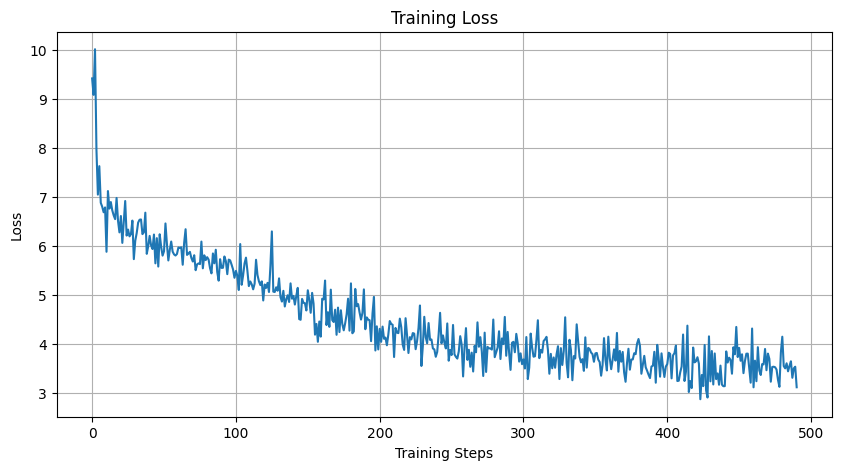

Episode 490, Average Loss: 3.4736


In [19]:
# Load the champion model
champion_model = load_champion_model("best_model.pth")  # Your 74% win-rate model

# Train new model with MCTS against champion
model = train_with_mcts(
    champion_model=champion_model,
    num_episodes=500,  # More episodes since this is a harder task
    mcts_simulations=400  # More simulations for better search
)

In [23]:
champion_model = load_champion_model("checkers_model_episode_50.pt")
winning_model = load_champion_model("checkers_model_episode_450.pt")

evaluate_with_mcts(
    current_model=champion_model,
    champion_model=winning_model
)

Evaluated 10 games: Wins: 10, Draws: 0, Losses: 0
Evaluated 20 games: Wins: 20, Draws: 0, Losses: 0
Evaluated 30 games: Wins: 30, Draws: 0, Losses: 0
Evaluated 40 games: Wins: 40, Draws: 0, Losses: 0
Evaluated 50 games: Wins: 50, Draws: 0, Losses: 0
Evaluated 60 games: Wins: 60, Draws: 0, Losses: 0
Evaluated 70 games: Wins: 70, Draws: 0, Losses: 0
Evaluated 80 games: Wins: 80, Draws: 0, Losses: 0
Evaluated 90 games: Wins: 90, Draws: 0, Losses: 0
Evaluated 100 games: Wins: 100, Draws: 0, Losses: 0

Evaluation Results with MCTS vs Champion:
Games played: 100
Win rate against champion: 100.00%
Draw rate: 0.00%
Loss rate: 0.00%


(1.0, 0.0, 0.0)

In [24]:
champion_model = load_champion_model("checkers_model_episode_350.pt")
winning_model = load_champion_model("checkers_model_episode_450.pt")

evaluate_with_mcts(
    current_model=champion_model,
    champion_model=winning_model
)

Evaluated 10 games: Wins: 0, Draws: 0, Losses: 10
Evaluated 20 games: Wins: 0, Draws: 0, Losses: 20
Evaluated 30 games: Wins: 0, Draws: 0, Losses: 30
Evaluated 40 games: Wins: 0, Draws: 0, Losses: 40
Evaluated 50 games: Wins: 0, Draws: 0, Losses: 50
Evaluated 60 games: Wins: 0, Draws: 0, Losses: 60
Evaluated 70 games: Wins: 0, Draws: 0, Losses: 70
Evaluated 80 games: Wins: 0, Draws: 0, Losses: 80
Evaluated 90 games: Wins: 0, Draws: 0, Losses: 90
Evaluated 100 games: Wins: 0, Draws: 0, Losses: 100

Evaluation Results with MCTS vs Champion:
Games played: 100
Win rate against champion: 0.00%
Draw rate: 0.00%
Loss rate: 100.00%


(0.0, 0.0, 1.0)

In [25]:
champion_model = load_champion_model("checkers_model_episode_150.pt")
winning_model = load_champion_model("checkers_model_episode_450.pt")

evaluate_with_mcts(
    current_model=champion_model,
    champion_model=winning_model
)

Evaluated 10 games: Wins: 10, Draws: 0, Losses: 0
Evaluated 20 games: Wins: 20, Draws: 0, Losses: 0
Evaluated 30 games: Wins: 30, Draws: 0, Losses: 0
Evaluated 40 games: Wins: 40, Draws: 0, Losses: 0
Evaluated 50 games: Wins: 50, Draws: 0, Losses: 0
Evaluated 60 games: Wins: 60, Draws: 0, Losses: 0
Evaluated 70 games: Wins: 70, Draws: 0, Losses: 0
Evaluated 80 games: Wins: 80, Draws: 0, Losses: 0
Evaluated 90 games: Wins: 90, Draws: 0, Losses: 0
Evaluated 100 games: Wins: 100, Draws: 0, Losses: 0

Evaluation Results with MCTS vs Champion:
Games played: 100
Win rate against champion: 100.00%
Draw rate: 0.00%
Loss rate: 0.00%


(1.0, 0.0, 0.0)

In [26]:
champion_model = load_champion_model("checkers_model_episode_250.pt")
winning_model = load_champion_model("checkers_model_episode_450.pt")

evaluate_with_mcts(
    current_model=champion_model,
    champion_model=winning_model
)

Evaluated 10 games: Wins: 10, Draws: 0, Losses: 0
Evaluated 20 games: Wins: 20, Draws: 0, Losses: 0
Evaluated 30 games: Wins: 30, Draws: 0, Losses: 0
Evaluated 40 games: Wins: 40, Draws: 0, Losses: 0
Evaluated 50 games: Wins: 50, Draws: 0, Losses: 0
Evaluated 60 games: Wins: 60, Draws: 0, Losses: 0
Evaluated 70 games: Wins: 70, Draws: 0, Losses: 0
Evaluated 80 games: Wins: 80, Draws: 0, Losses: 0
Evaluated 90 games: Wins: 90, Draws: 0, Losses: 0
Evaluated 100 games: Wins: 100, Draws: 0, Losses: 0

Evaluation Results with MCTS vs Champion:
Games played: 100
Win rate against champion: 100.00%
Draw rate: 0.00%
Loss rate: 0.00%


(1.0, 0.0, 0.0)

In [27]:
champion_model = load_champion_model("checkers_model_episode_300.pt")
winning_model = load_champion_model("checkers_model_episode_450.pt")

evaluate_with_mcts(
    current_model=champion_model,
    champion_model=winning_model
)

Evaluated 10 games: Wins: 10, Draws: 0, Losses: 0
Evaluated 20 games: Wins: 20, Draws: 0, Losses: 0
Evaluated 30 games: Wins: 30, Draws: 0, Losses: 0
Evaluated 40 games: Wins: 40, Draws: 0, Losses: 0
Evaluated 50 games: Wins: 50, Draws: 0, Losses: 0
Evaluated 60 games: Wins: 60, Draws: 0, Losses: 0
Evaluated 70 games: Wins: 70, Draws: 0, Losses: 0
Evaluated 80 games: Wins: 80, Draws: 0, Losses: 0
Evaluated 90 games: Wins: 90, Draws: 0, Losses: 0
Evaluated 100 games: Wins: 100, Draws: 0, Losses: 0

Evaluation Results with MCTS vs Champion:
Games played: 100
Win rate against champion: 100.00%
Draw rate: 0.00%
Loss rate: 0.00%


(1.0, 0.0, 0.0)

In [18]:
def calculate_elo_change(rating_a, rating_b, score_a, k=32):
    """Calculate ELO rating change for player A."""
    expected_a = 1 / (1 + 10**((rating_b - rating_a) / 400))
    return k * (score_a - expected_a)

def evaluate_models_elo(model_a, model_b, num_games=100, k_factor=32, initial_elo=1200, mcts_simulations=50):
    """
    Evaluate two models against each other using MCTS and calculate their ELO ratings.
    
    Args:
        model_a: First neural network model to evaluate
        model_b: Second neural network model to evaluate
        num_games: Number of games to play
        k_factor: ELO K-factor (determines how quickly ratings can change)
        initial_elo: Starting ELO rating for both models
        mcts_simulations: Number of MCTS simulations per move
    
    Returns:
        Tuple containing (elo_histories, final_elos, game_stats)
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_a.eval()
    model_b.eval()
    
    mcts_a = MCTS(model_a, device, num_simulations=mcts_simulations)
    mcts_b = MCTS(model_b, device, num_simulations=mcts_simulations)
    
    elo_a = initial_elo
    elo_b = initial_elo
    elo_history_a = [elo_a]
    elo_history_b = [elo_b]
    
    wins_a = 0
    draws = 0
    wins_b = 0
    
    for game in range(num_games):
        board = CheckersBoard()
        move_count = 0
        max_moves = 200
        
        # Alternate which model plays first
        model_a_is_player_1 = (game % 2 == 0)
        
        while move_count < max_moves:
            legal_moves = board.get_legal_moves()
            if not legal_moves:
                if (board.current_player == 1 and model_a_is_player_1) or \
                   (board.current_player == 2 and not model_a_is_player_1):
                    # Model A loses
                    wins_b += 1
                    score_a = 0.0
                    score_b = 1.0
                else:
                    # Model B loses
                    wins_a += 1
                    score_a = 1.0
                    score_b = 0.0
                break
            
            # Determine which model is playing this turn
            is_model_a_turn = (board.current_player == 1 and model_a_is_player_1) or \
                             (board.current_player == 2 and not model_a_is_player_1)
            
            if is_model_a_turn:
                # Model A's turn
                moves, probs = mcts_a.search(board)
                if moves:
                    best_idx = np.argmax(probs)
                    selected_move = moves[best_idx]
                else:
                    selected_move = random.choice(legal_moves)
            else:
                # Model B's turn
                moves, probs = mcts_b.search(board)
                if moves:
                    best_idx = np.argmax(probs)
                    selected_move = moves[best_idx]
                else:
                    selected_move = random.choice(legal_moves)
            
            board.make_move(selected_move)
            move_count += 1
            
            if move_count >= max_moves:
                draws += 1
                score_a = 0.5
                score_b = 0.5
                break
        
        # Update ELO ratings
        elo_change_a = calculate_elo_change(elo_a, elo_b, score_a, k_factor)
        elo_change_b = calculate_elo_change(elo_b, elo_a, score_b, k_factor)
        
        elo_a += elo_change_a
        elo_b += elo_change_b
        
        elo_history_a.append(elo_a)
        elo_history_b.append(elo_b)
        
        # Print progress every 10 games
        if (game + 1) % 10 == 0:
            print(f"Completed {game + 1} games.")
            print(f"Model A - ELO: {elo_a:.1f}, Wins: {wins_a}")
            print(f"Model B - ELO: {elo_b:.1f}, Wins: {wins_b}")
            print(f"Draws: {draws}")
    
    # Create visualization
    plt.figure(figsize=(12, 7))
    
    # ELO evolution plots
    plt.plot(range(num_games + 1), elo_history_a, '-b', label='Model A ELO Rating', linewidth=2)
    plt.plot(range(num_games + 1), elo_history_b, '-r', label='Model B ELO Rating', linewidth=2)
    
    # Add rolling averages
    window = min(20, num_games // 5)  # Dynamic window size
    if window > 1:
        rolling_avg_a = np.convolve(elo_history_a, np.ones(window)/window, mode='valid')
        rolling_avg_b = np.convolve(elo_history_b, np.ones(window)/window, mode='valid')
        
        plt.plot(range(window-1, len(rolling_avg_a) + window-1), rolling_avg_a, 
                'b--', label=f'Model A {window}-game Moving Average', alpha=0.7)
        plt.plot(range(window-1, len(rolling_avg_b) + window-1), rolling_avg_b, 
                'r--', label=f'Model B {window}-game Moving Average', alpha=0.7)
    
    plt.title('ELO Rating Evolution: Model A vs Model B', fontsize=14)
    plt.xlabel('Number of Games Played', fontsize=12)
    plt.ylabel('ELO Rating', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    
    # Add statistics text box
    win_rate_a = wins_a / num_games * 100
    win_rate_b = wins_b / num_games * 100
    draw_rate = draws / num_games * 100
    
    stats_text = (f'Final ELOs: A={elo_a:.1f}, B={elo_b:.1f}\n'
                 f'Games Played: {num_games}\n'
                 f'Win Rates: A={win_rate_a:.1f}%, B={win_rate_b:.1f}%\n'
                 f'Wins: A={wins_a}, B={wins_b}, Draws={draws}')
    
    plt.text(0.02, 0.98, stats_text, 
             transform=plt.gca().transAxes, 
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.8),
             fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Return results
    elo_histories = (elo_history_a, elo_history_b)
    final_elos = (elo_a, elo_b)
    game_stats = (wins_a, draws, wins_b)
    
    return elo_histories, final_elos, game_stats


Completed 10 games.
Model A - ELO: 1310.5, Wins: 10
Model B - ELO: 1089.5, Wins: 0
Draws: 0
Completed 20 games.
Model A - ELO: 1365.4, Wins: 20
Model B - ELO: 1034.6, Wins: 0
Draws: 0
Completed 30 games.
Model A - ELO: 1400.6, Wins: 30
Model B - ELO: 999.4, Wins: 0
Draws: 0
Completed 40 games.
Model A - ELO: 1426.1, Wins: 40
Model B - ELO: 973.9, Wins: 0
Draws: 0
Completed 50 games.
Model A - ELO: 1446.1, Wins: 50
Model B - ELO: 953.9, Wins: 0
Draws: 0
Completed 60 games.
Model A - ELO: 1462.5, Wins: 60
Model B - ELO: 937.5, Wins: 0
Draws: 0
Completed 70 games.
Model A - ELO: 1476.3, Wins: 70
Model B - ELO: 923.7, Wins: 0
Draws: 0
Completed 80 games.
Model A - ELO: 1488.3, Wins: 80
Model B - ELO: 911.7, Wins: 0
Draws: 0
Completed 90 games.
Model A - ELO: 1498.9, Wins: 90
Model B - ELO: 901.1, Wins: 0
Draws: 0
Completed 100 games.
Model A - ELO: 1508.4, Wins: 100
Model B - ELO: 891.6, Wins: 0
Draws: 0


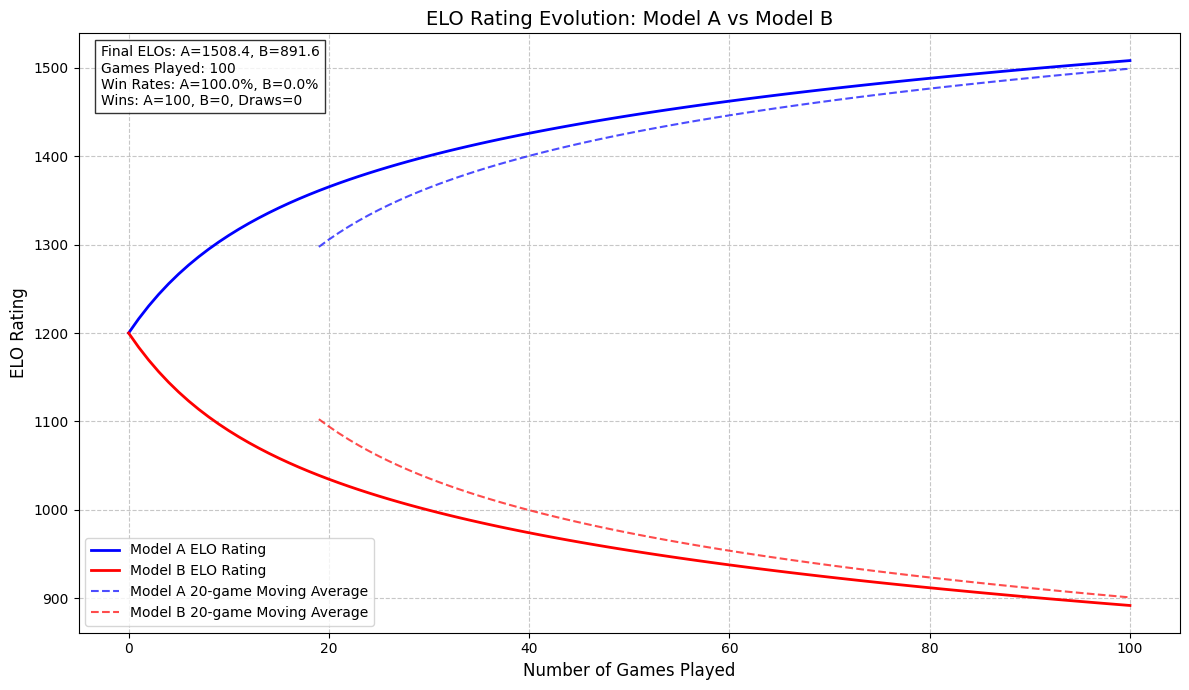

In [19]:
# Example usage
model_a = load_champion_model("checkers_model_episode_300.pt")
model_b = load_champion_model("checkers_model_episode_450.pt")

elo_histories, final_elos, game_stats = evaluate_models_elo(
    model_a=model_a,
    model_b=model_b,
    num_games=100,
    k_factor=32,
    initial_elo=1200,
    mcts_simulations=50
)